## **Mediation Analysis**
---

## Input

### Libraries

In [1]:
# Library
spsm <- suppressPackageStartupMessages 
spsm(library(dplyr))
spsm(library(tidyverse))
spsm(library(FactoMineR))
spsm(library(ggplot2))
spsm(library(factoextra))
spsm(library(corrplot))
spsm(library(mediation))
spsm(library(mosaic))
spsm(library(kableExtra))
spsm(library(IRdisplay))
spsm(library(vioplot))

### Ext. Functions

In [2]:
# Function
source("../../utils/getData.R")
source("../../utils/getPCs.R")
source("../../utils/getPermut.R")
source("../../utils/getMediationTable.R")
source("../../utils/imputeBOCF.R")
source("../../utils/imputeLOCF.R")

### Load data at 12-month

In [3]:
# example: dat <- getData("../../../data/", 1)
# options: 1: "SummaryMonths1to4.csv"
#          2: "SummaryMonths1to12.csv"
#          3: "SummaryMonths5to12Weight.csv
#          4: "SummaryMonths5to12All.csv"
pathFile <- c("../../../data/")
numFile <- 2
dat <- getData(pathFile, numFile)

In [4]:
names(dat)

[1] "id"                 "WeightLoss4Month"   "WeightLoss12Month" 
 [4] "Class4Month"        "Class12Month"       "Treatment"         
 [7] "Age"                "Gender"             "logInitialWeight"  
[10] "NumWeekendDays"     "NumWeekdayDays"     "NumWeigh"          
[13] "TotalEntries"       "TotalFoodDays"      "TotalExerciseDays" 
[16] "TotalBreakfastDays" "TotalLunchDays"     "TotalDinnerDays"   
[19] "TotalSnackDays"     "AvgTotalCal"        "AvgExerciseCal"    
[22] "AvgBreakfastCal"    "AvgLunchCal"        "AvgDinnerCal"      
[25] "AvgSnackCal"

### Data description

The data variables used in our mediation analysis are described as follows:   
* *Treatment* is the treatment assignment variable, where it equals 0 for self-paced subjects and 1 for counselor-initiated subjects.  

* *WeightLoss12Month* is a log-ratio indicating the rate of weight change at four months with respect to the baseline weight. If the value is positive, it indicates a weight loss; if it is negative, it corresponds to gain, and 0 indicates no change between 12 months and baseline.   

* *WeightLoss4Month* is a log-ratio indicating the rate of weight change at four months with respect to the baseline weight. If the value is positive, it indicates a weight loss; if it is negative, it corresponds to gain, and 0 indicates no change between 4 months and baseline.   

* The potential mediators that we plan to analyze are the *self-weighing* variable and the principal components derived from the electronically collected variables' PCA. The logging variables quantify logging behavior in a number of days, and the caloric variables assess caloric intake and output. The logging and caloric variables are estimated over 4 months for the 4-month mediation analysis and 12 months for the 12-month mediation analysis. The average caloric variables quantify the sum of the calories divided by the total number of logged days. For example, *AvgBreakfastCal* equals the sum of intake calories reported at breakfast divided by the total number of days when breakfast was logged.

   
| Logging            | Caloric         |
|--------------------|-----------------|
| NumWeekendDays     | AvgTotalCal     | 
| NumWeekdayDays     | AvgExerciseCal  |
| TotalEntries       | AvgBreakfastCal |
| TotalFoodDays      | AvgLunchCal     |
| TotalExerciseDays  | AvgDinnerCal    |
| TotalBreakfastDays | AvgSnackCal     |
| TotalLunchDays     |                 |
| TotalDinnerDays    |                 |
| TotalSnackDays     |                 |



---
## Principal Component Analysis

Applying a PCA (principal component analysis) reduces the number of variables and adresses the multicollinearity of the electronically collected variables.


### Variables selection

In [5]:
# Select the variable indexes to include in the Principal Component Analysis
myCols <-c("NumWeekendDays","NumWeekdayDays", "TotalEntries", "TotalFoodDays", "TotalExerciseDays",
          "TotalBreakfastDays", "TotalLunchDays", "TotalDinnerDays", "TotalSnackDays", "AvgTotalCal", 
           "AvgExerciseCal", "AvgBreakfastCal", "AvgLunchCal", "AvgDinnerCal", "AvgSnackCal")
# Get the indexes of those variables
idxApp <- match(myCols, colnames(dat))

### Apply the PCA

In [6]:
# Get the results of PCA
resPC <- getPCs(dat, idxApp, numPCs = 3) # max numPCs is 5
# Get the data frame including the first three principal components named app1, app2, app3.
dat <- resPC$data

Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4



In [7]:
# Display the variables name
# print(names(dat))
# Select variables of interest
if (numFile == 1){
  myCols <-c("id","WeightLoss4Month", "Treatment", "Age", "NumWeigh", "App1", "App2", "App3")  
} else {
  myCols <-c("id","WeightLoss12Month", "WeightLoss4Month", "Treatment", "Age", "NumWeigh", "App1", "App2", "App3")      
}

myIdx <- match(myCols, colnames(dat))
dat <- dat[, myIdx]
print(names(dat))

[1] "id"                "WeightLoss12Month" "WeightLoss4Month" 
[4] "Treatment"         "Age"               "NumWeigh"         
[7] "App1"              "App2"              "App3"             


### Display PCA results

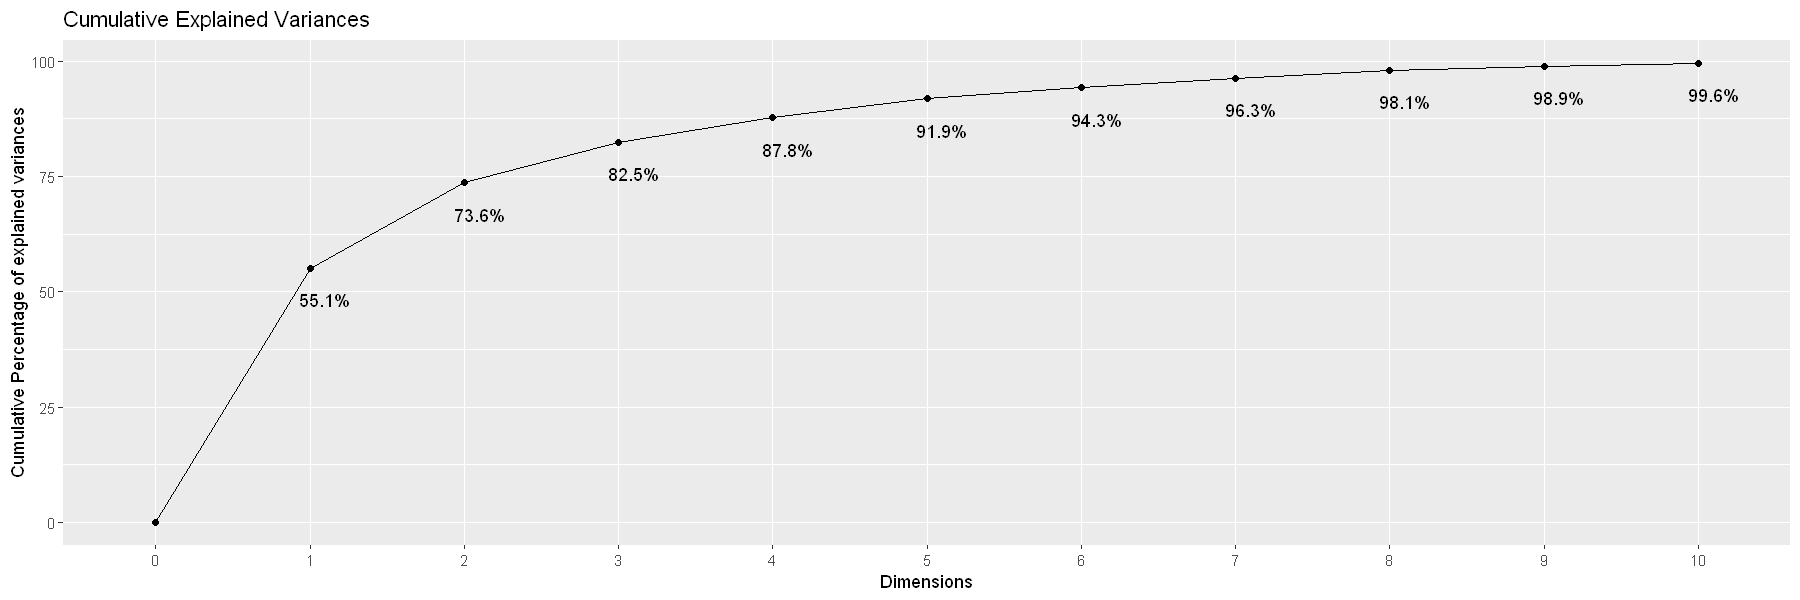

In [8]:
# resPC contains also the scree plot{scree.plot}, cumulative variance explained {CV.plot}, 
# the variables contribution of each component {contribCorr.plot()} and the quality of those 
# contributions {cos2Corr.plot()}.
options(repr.plot.width = 15, repr.plot.height = 5)
resPC$CV.plot

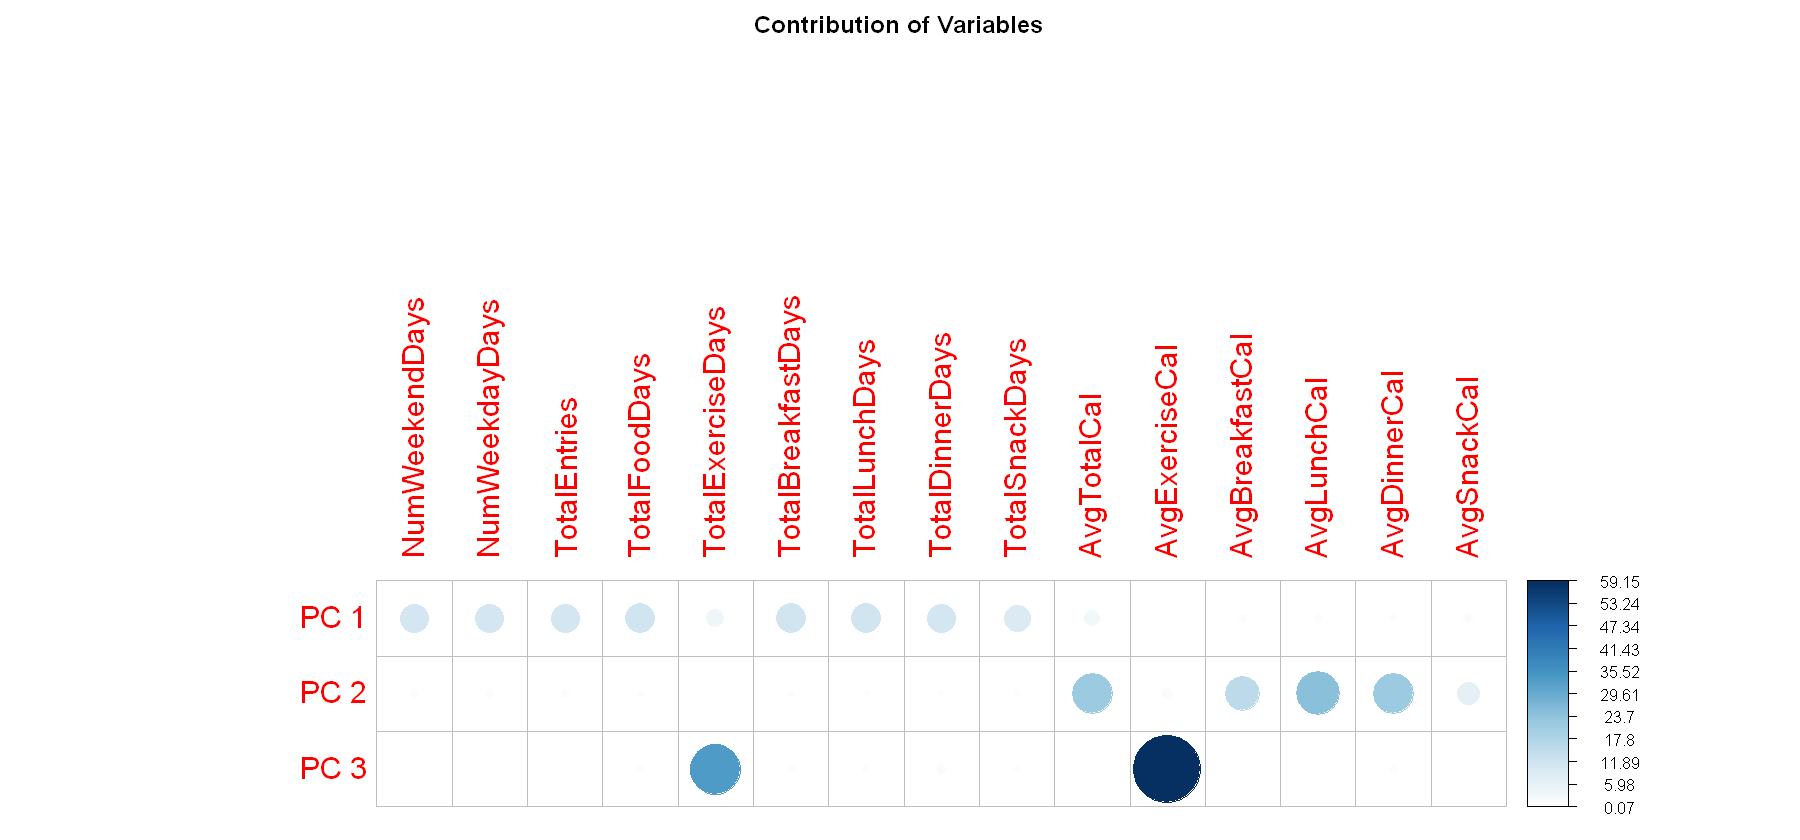

In [9]:
options(repr.plot.width = 15, repr.plot.height = 7)
resPC$contribCorr.plot(1.5) # to get numbers use resPC$contribCorrNum.plot()

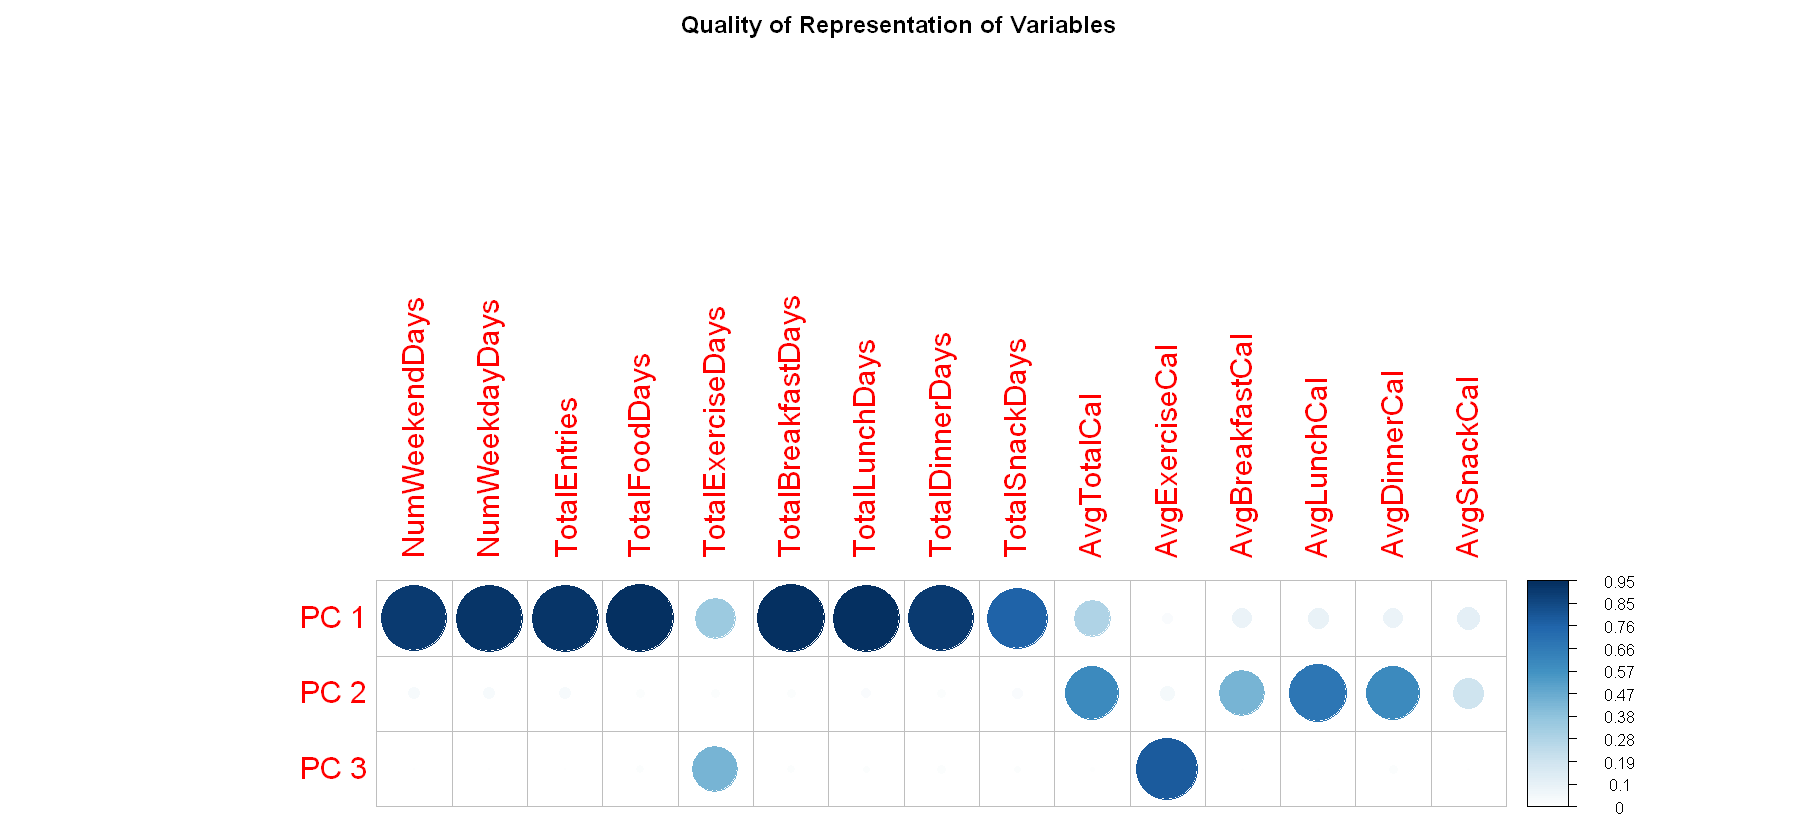

In [10]:
options(repr.plot.width = 15, repr.plot.height = 7)
resPC$cos2Corr.plot(1.5) # to get numbers use resPC$cos2CorrNum.plot()

---
## Analysis

The first step of the mediation analysis is to establish if our candidates variables are mediators or not.    
**To analyze the mediation we observe the following flowchart:**

![alt text](images/Mediation_flowchart.svg "Mediation Analysis flowchart")

**We first estimated two linear regressions for both the mediator and the outcome. We used also a permutation test to assess any associations with respect to our samples.**

**Clean the data:** *impute with the last observation carried forward*

In [11]:
dat <- imputeLOCF(dat, response = "both")

---
### Relationship association assessment

We will consider the following assumptions:

* App usage and Number of self-weighing are casually unrelated mediators.
* Observed confounder is : age. 

#### **Regression of weight loss on the treatment.**

In [12]:
# Outcome model with confounders
out.fit <- lm(WeightLoss12Month ~ Treatment + Age, data = dat)
#  out.fit <- lm(WeightLoss12Month ~ Treatment + Age + Gender + logInitialWeight , data = dat)
summary(out.fit)


Call:
lm(formula = WeightLoss12Month ~ Treatment + Age, data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.16213 -0.02975 -0.00272  0.03032  0.21996 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept) -0.0485109  0.0182602  -2.657  0.00857 **
Treatment    0.0231023  0.0077591   2.977  0.00329 **
Age          0.0014037  0.0005116   2.744  0.00666 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.05315 on 188 degrees of freedom
Multiple R-squared:  0.08887,	Adjusted R-squared:  0.07918 
F-statistic: 9.168 on 2 and 188 DF,  p-value: 0.0001587


#### **Permutation test: Weight loss ~ treatment assignment**

The mean weight loss for intervention is: 0.02448291 
The mean weight loss for no intervention is: -0.0008819092 
The absolute t-test statistic is:  3.256987 
Number of permutation sample: 10000 
P-value with t-test for 10000 samples is 5e-04 .


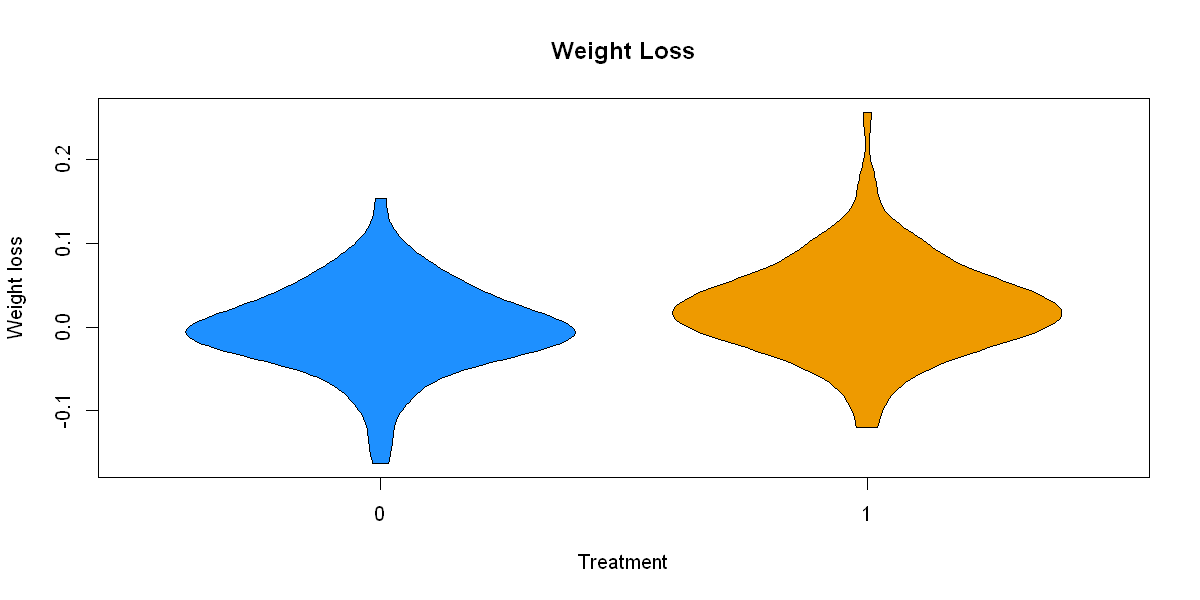

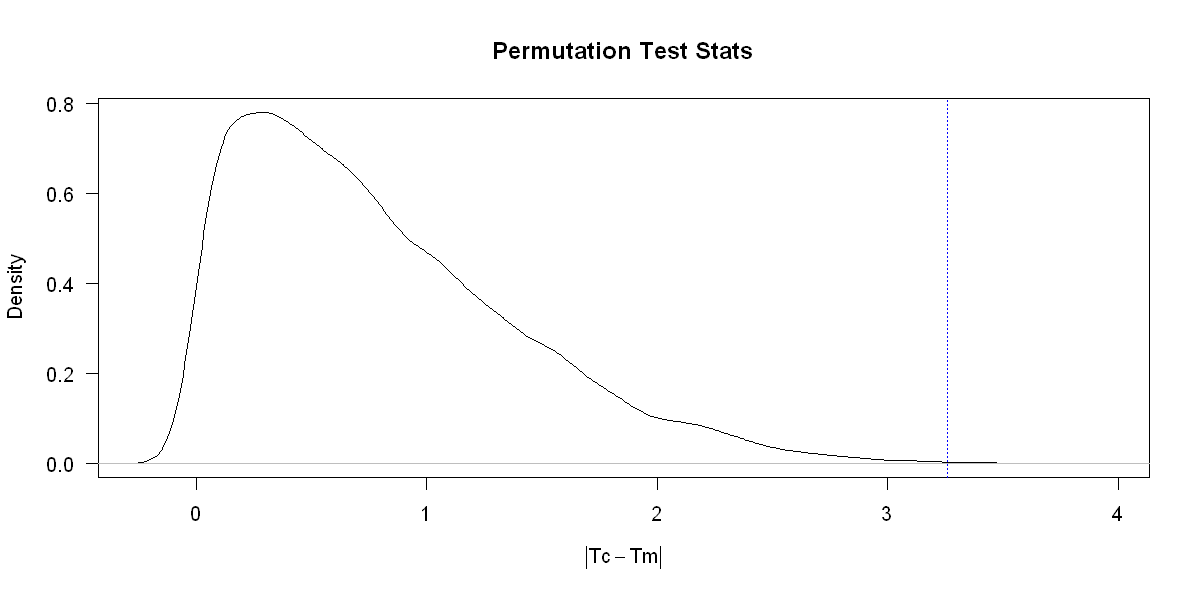

In [13]:
options(repr.plot.width = 10, repr.plot.height = 5)
getPermut(dat$WeightLoss12Month, dat$Treatment, P = 10000)

***We confirmed that the treatment has a statistically significant predictive capability on weight loss outcome.***

#### **Regression of App-usage (*i.e.*, PC1 ) on the treatment.**

In [14]:
# Outcome model with confounders
out.fit <- lm(App1 ~ Treatment + Age, data = dat)
summary(out.fit)


Call:
lm(formula = App1 ~ Treatment + Age, data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.2982 -1.3647 -0.2957  1.5327  7.3369 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.17705    0.77744  -5.373 2.27e-07 ***
Treatment    3.34443    0.33035  10.124  < 2e-16 ***
Age          0.06820    0.02178   3.131  0.00202 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.263 on 188 degrees of freedom
Multiple R-squared:  0.3904,	Adjusted R-squared:  0.3839 
F-statistic:  60.2 on 2 and 188 DF,  p-value: < 2.2e-16


#### **Permutation test: App-usage ~ treatment assignment**

The mean weight loss for intervention is: 1.591541 
The mean weight loss for no intervention is: -1.862826 
The absolute t-test statistic is:  10.61902 
Number of permutation sample: 10000 
P-value with t-test for 10000 samples is 0 .


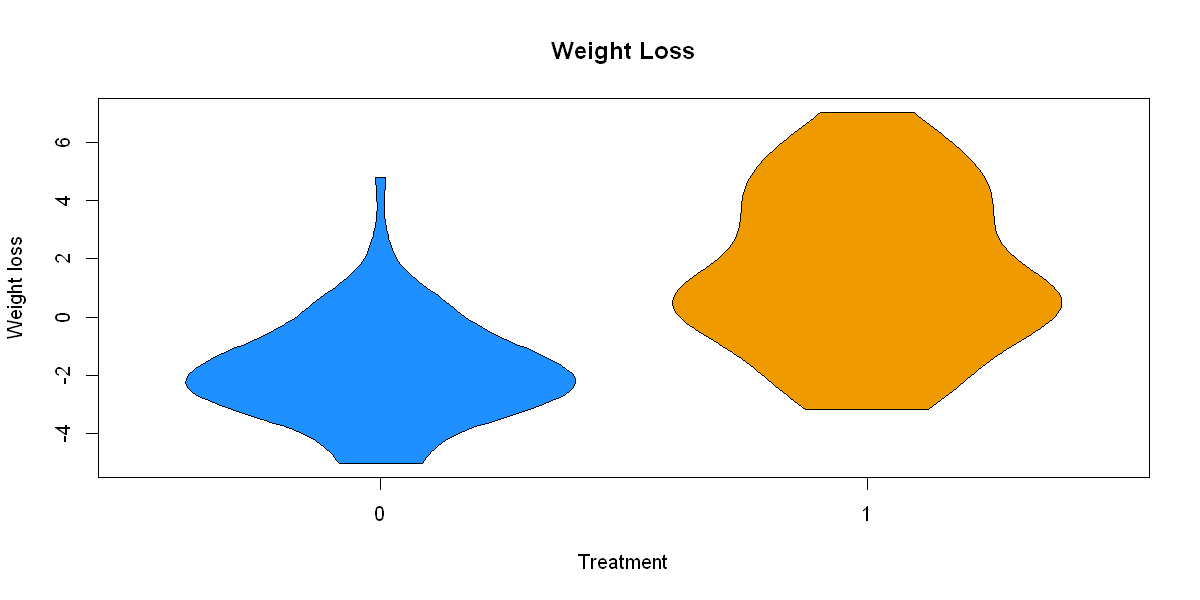

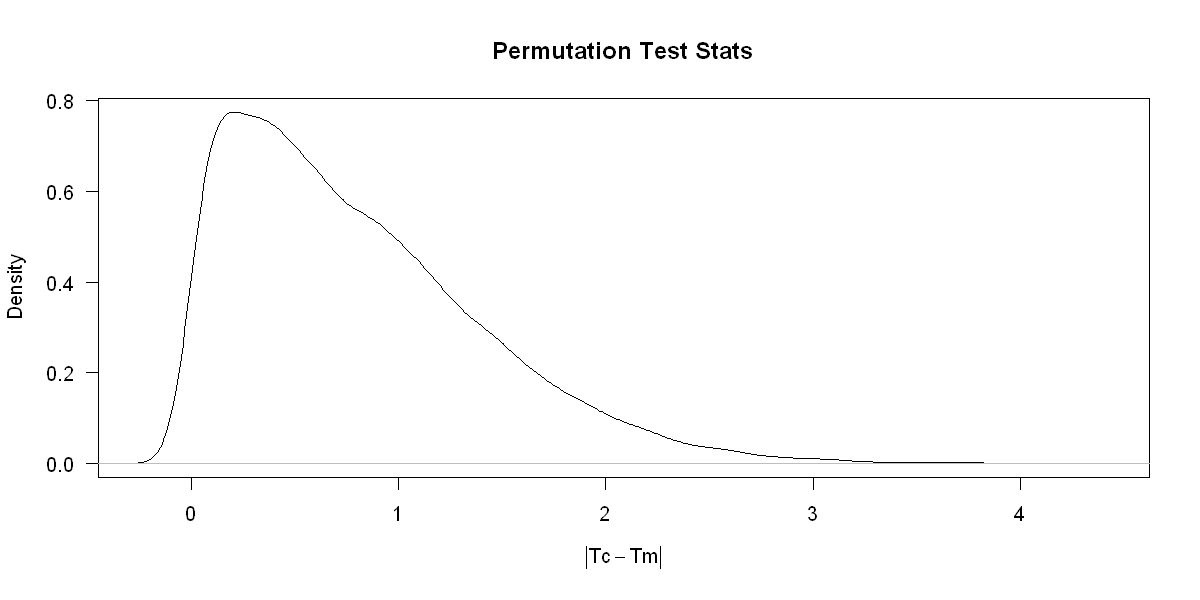

In [15]:
getPermut(dat$App1, dat$Treatment, P = 10000)

#### **Regression of App-calories (*i.e.*, PC2 ) on the treatment.**

In [16]:
# Outcome model with confounders
out.fit <- lm(App2 ~ Treatment + Age, data = dat)
summary(out.fit)


Call:
lm(formula = App2 ~ Treatment + Age, data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.5074 -0.9173 -0.0026  0.7767  5.3341 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.64990    0.57363  -1.133    0.259
Treatment    0.26784    0.24375   1.099    0.273
Age          0.01452    0.01607   0.904    0.367

Residual standard error: 1.67 on 188 degrees of freedom
Multiple R-squared:  0.01188,	Adjusted R-squared:  0.001371 
F-statistic:  1.13 on 2 and 188 DF,  p-value: 0.3251


#### **Permutation test: App-calories ~ treatment assignment**

The mean weight loss for intervention is: 0.1341901 
The mean weight loss for no intervention is: -0.1570634 
The absolute t-test statistic is:  1.166119 
Number of permutation sample: 10000 
P-value with t-test for 10000 samples is 0.2464 .


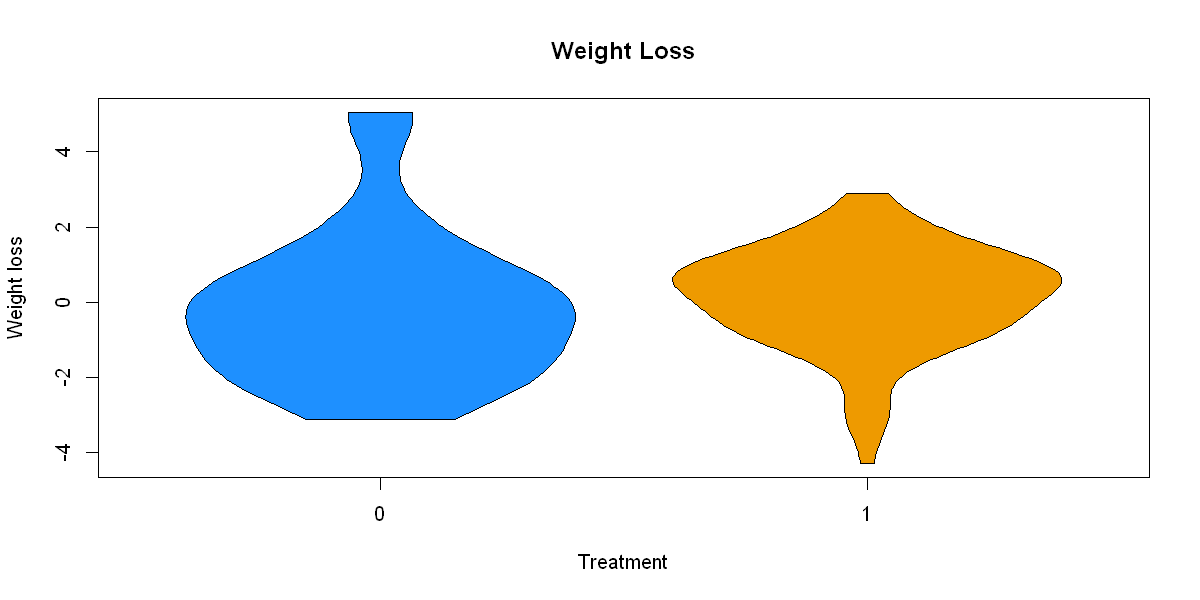

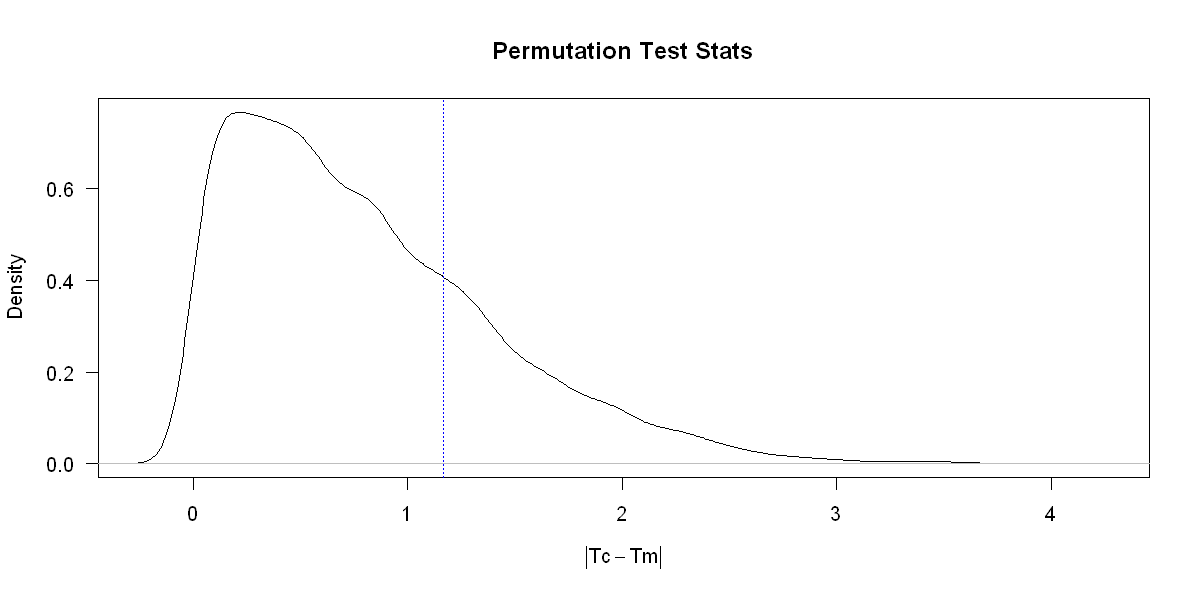

In [17]:
getPermut(dat$App2, dat$Treatment, P = 10000)

#### **Regression of App-exercise (*i.e.*, PC3 ) on the treatment.**

In [18]:
# Outcome model with confounders
out.fit <- lm(App3 ~ Treatment + Age, data = dat)
summary(out.fit)


Call:
lm(formula = App3 ~ Treatment + Age, data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1625 -0.8839  0.0164  0.7262  4.1827 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.972935   0.392492   2.479   0.0141 *
Treatment    0.003746   0.166778   0.022   0.9821  
Age         -0.028015   0.010996  -2.548   0.0116 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.142 on 188 degrees of freedom
Multiple R-squared:  0.03368,	Adjusted R-squared:  0.0234 
F-statistic: 3.277 on 2 and 188 DF,  p-value: 0.03992


#### **Permutation test: App-exercise ~ treatment assignment**

The mean weight loss for intervention is: -0.01907944 
The mean weight loss for no intervention is: 0.02233161 
The absolute t-test statistic is:  0.2497284 
Number of permutation sample: 10000 
P-value with t-test for 10000 samples is 0.8029 .


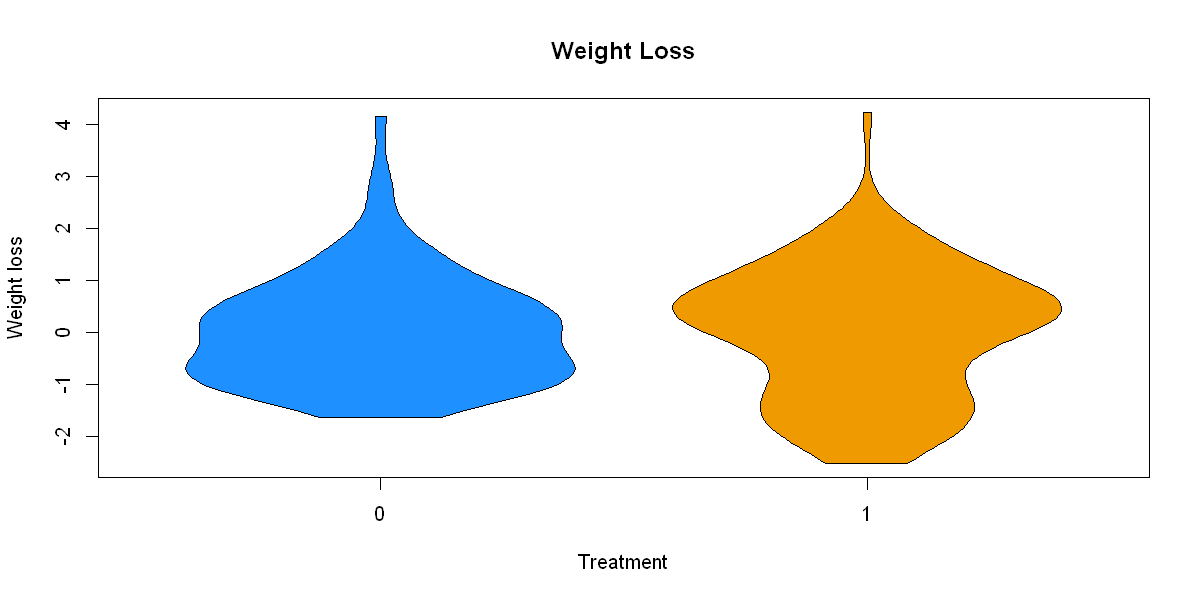

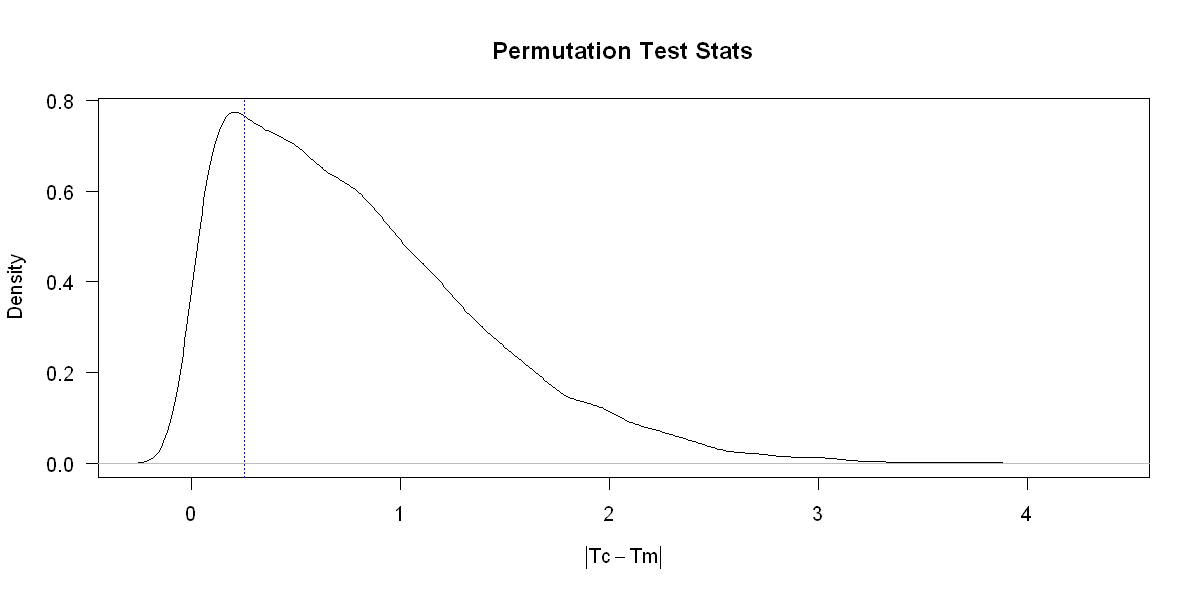

In [19]:
getPermut(dat$App3, dat$Treatment, P = 10000)

#### **Regression of Self-weight on the treatment.**

In [20]:
# Outcome model with confounders
out.fit <- lm(NumWeigh ~ Treatment + Age, data = dat)
summary(out.fit)


Call:
lm(formula = NumWeigh ~ Treatment + Age, data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-181.30  -67.24   -9.76   60.00  211.56 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  36.8759    30.3911   1.213  0.22651    
Treatment    65.7413    12.9139   5.091 8.62e-07 ***
Age           2.2689     0.8515   2.665  0.00837 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 88.46 on 188 degrees of freedom
Multiple R-squared:  0.1619,	Adjusted R-squared:  0.153 
F-statistic: 18.16 on 2 and 188 DF,  p-value: 6.181e-08


#### **Permutation test: Self-weight ~ treatment assignment**

The mean weight loss for intervention is: 183.2621 
The mean weight loss for no intervention is: 113.8636 
The absolute t-test statistic is:  5.334704 
Number of permutation sample: 10000 
P-value with t-test for 10000 samples is 0 .


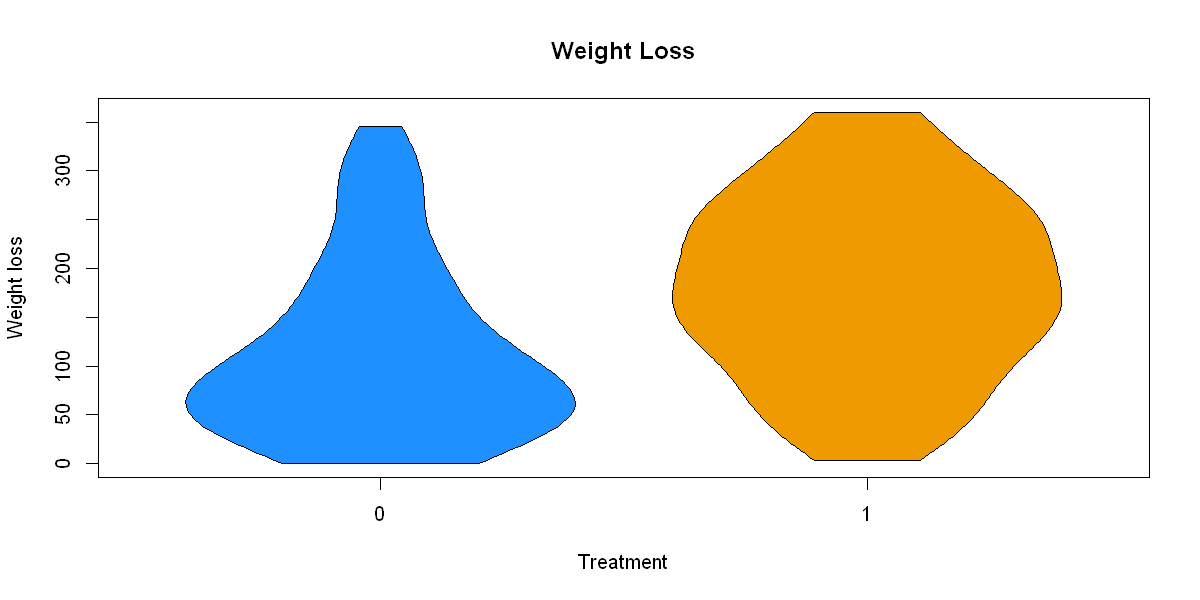

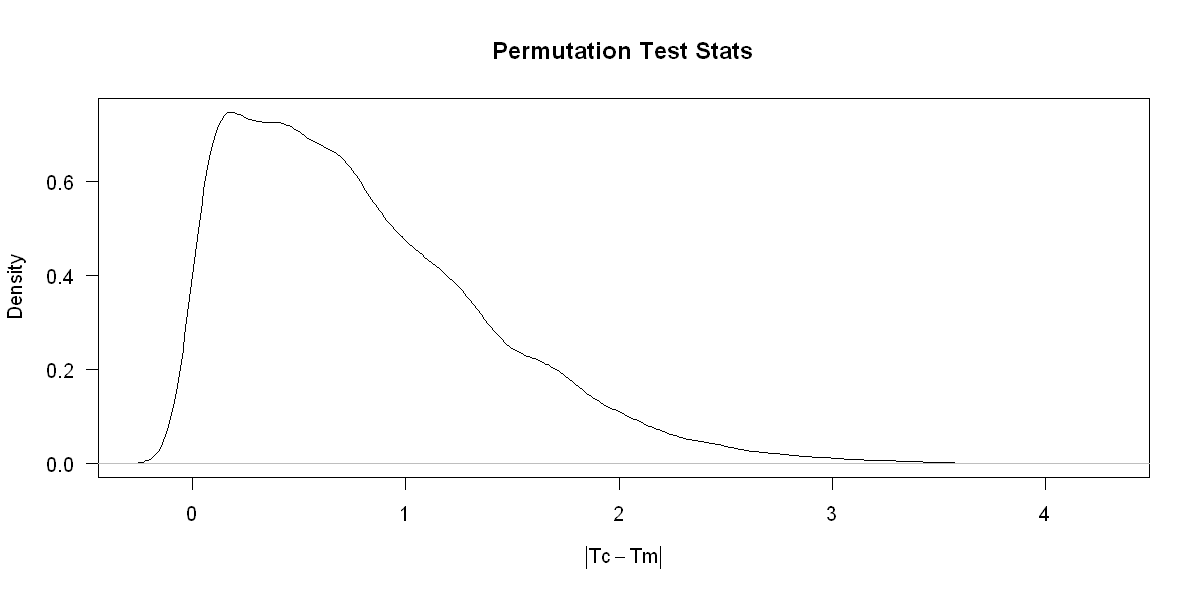

In [21]:
getPermut(dat$NumWeigh, dat$Treatment, P = 10000)

#### **Regression of 4-month weight loss on the treatment.**

In [22]:
# Outcome model with confounders
out.fit <- lm(WeightLoss4Month ~ Treatment + Age, data = dat)
summary(out.fit)


Call:
lm(formula = WeightLoss4Month ~ Treatment + Age, data = dat)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.06795 -0.02433 -0.00409  0.01578  0.18390 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0204494  0.0127192  -1.608    0.110    
Treatment    0.0311281  0.0054047   5.759 3.39e-08 ***
Age          0.0007652  0.0003563   2.147    0.033 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.03702 on 188 degrees of freedom
Multiple R-squared:  0.1786,	Adjusted R-squared:  0.1698 
F-statistic: 20.44 on 2 and 188 DF,  p-value: 9.31e-09


#### **Permutation test: 4-month weight loss ~ treatment assignment**

The mean weight loss for intervention is: 0.03787648 
The mean weight loss for no intervention is: 0.005514997 
The absolute t-test statistic is:  6.115735 
Number of permutation sample: 10000 
P-value with t-test for 10000 samples is 0 .


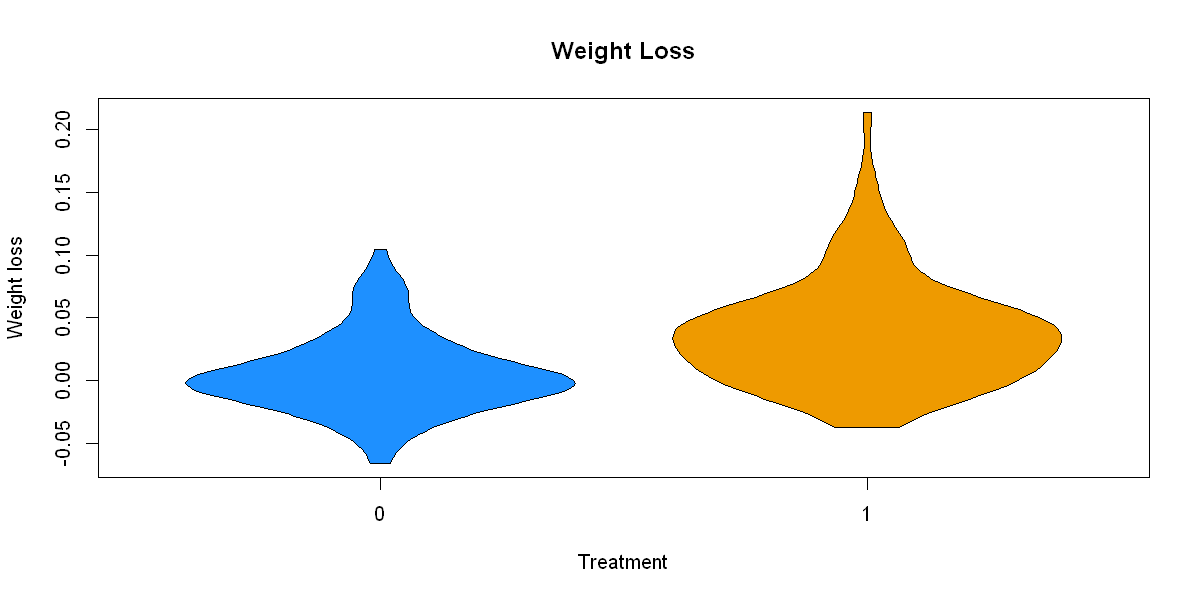

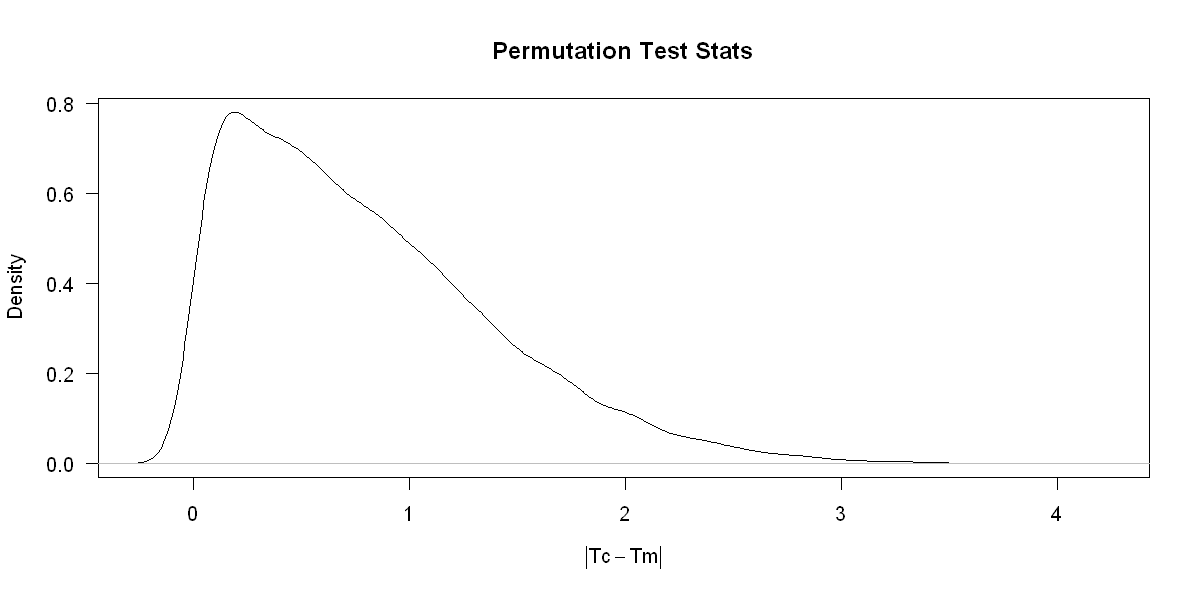

In [23]:
getPermut(dat$WeightLoss4Month, dat$Treatment, P = 10000)

***We confirmed that the treatment has a statistically significant predictive capability on all potential mediators except for the app-exercise. Since app-usage variable (i.e., PC1) explained more than 55% of the variance, we considered only app-usage, self-weight and the 4-month weight loss variables for the mediation analysis for the 12 month-weight loss.***

---
## Mediation

**Our function `getMediationTable` to estimate the Average Causal Mediation Effect (ACME) and the Average Direct Effect (ADE) associated with each mediator is based on  the `mediation` library.**

In [24]:
numFile <- 2
rslts <- getMediationTable(dat, numFile, myRobustSE = TRUE, numSims = 10000, confLvl = 0.90) 


### **Mediation Results** 


In [25]:
rslts$med.tbl %>% round(5)%>%
  kable("html") %>% 
  column_spec(c(1), bold = T, color = "black") %>%
  column_spec(c(2, 5, 8), bold = T, color = "steelblue") %>%
  column_spec(c(3, 4, 6, 7, 9, 10), bold = T, color = "sienna") %>%
  column_spec(c(11), bold = T, color = "black")%>%
  as.character() %>%
  display_html()

,Total Effect,Lower CI,Upper CI,ADE,Lower CI,Upper CI,ACME,Lower CI,Upper CI,Prop. Mediated
App-usage,0.02328,0.01058,0.03589,0.00406,-0.01186,0.01995,0.01921,0.00966,0.02929,0.82418
Self-weight,0.02298,0.01040,0.03592,0.00948,-0.00191,0.02079,0.01350,0.00754,0.02033,0.58562
4 Months Weight Loss,0.02313,0.01010,0.03601,-0.00180,-0.01272,0.00886,0.02493,0.01669,0.03382,1.07731


---
## Sensitivity Analysis

In [26]:
# Sensitivity for the 4-month weight loss
sens4Month.out <- medsens(rslts$med.rslts$med4Month.out, rho.by = 0.01, effect.type = "indirect", sims = 10000)

In [27]:
# Sensitivity for the app-usage
sensApp.out <- medsens(rslts$med.rslts$medApp.out, rho.by = 0.01, effect.type = "indirect", sims = 10000)
# Sensitivity for the self-weight
sensNumW.out <- medsens(rslts$med.rslts$medNumW.out, rho.by = 0.01, effect.type = "indirect", sims = 10000)

### 4-month weight loss

#### Results

In [28]:
summary(sens4Month.out)


Mediation Sensitivity Analysis for Average Causal Mediation Effect

Sensitivity Region

       Rho    ACME 90% CI Lower 90% CI Upper R^2_M*R^2_Y* R^2_M~R^2_Y~
 [1,] 0.48  0.0045      -0.0002       0.0093       0.2304       0.1191
 [2,] 0.49  0.0040      -0.0008       0.0087       0.2401       0.1241
 [3,] 0.50  0.0034      -0.0013       0.0081       0.2500       0.1292
 [4,] 0.51  0.0028      -0.0018       0.0075       0.2601       0.1345
 [5,] 0.52  0.0022      -0.0024       0.0069       0.2704       0.1398
 [6,] 0.53  0.0016      -0.0030       0.0063       0.2809       0.1452
 [7,] 0.54  0.0010      -0.0036       0.0056       0.2916       0.1507
 [8,] 0.55  0.0004      -0.0042       0.0050       0.3025       0.1564
 [9,] 0.56 -0.0002      -0.0049       0.0044       0.3136       0.1621
[10,] 0.57 -0.0009      -0.0055       0.0037       0.3249       0.1679
[11,] 0.58 -0.0016      -0.0062       0.0030       0.3364       0.1739
[12,] 0.59 -0.0023      -0.0069       0.0024       0.3481  

#### Sensitivity with respect to error correlation

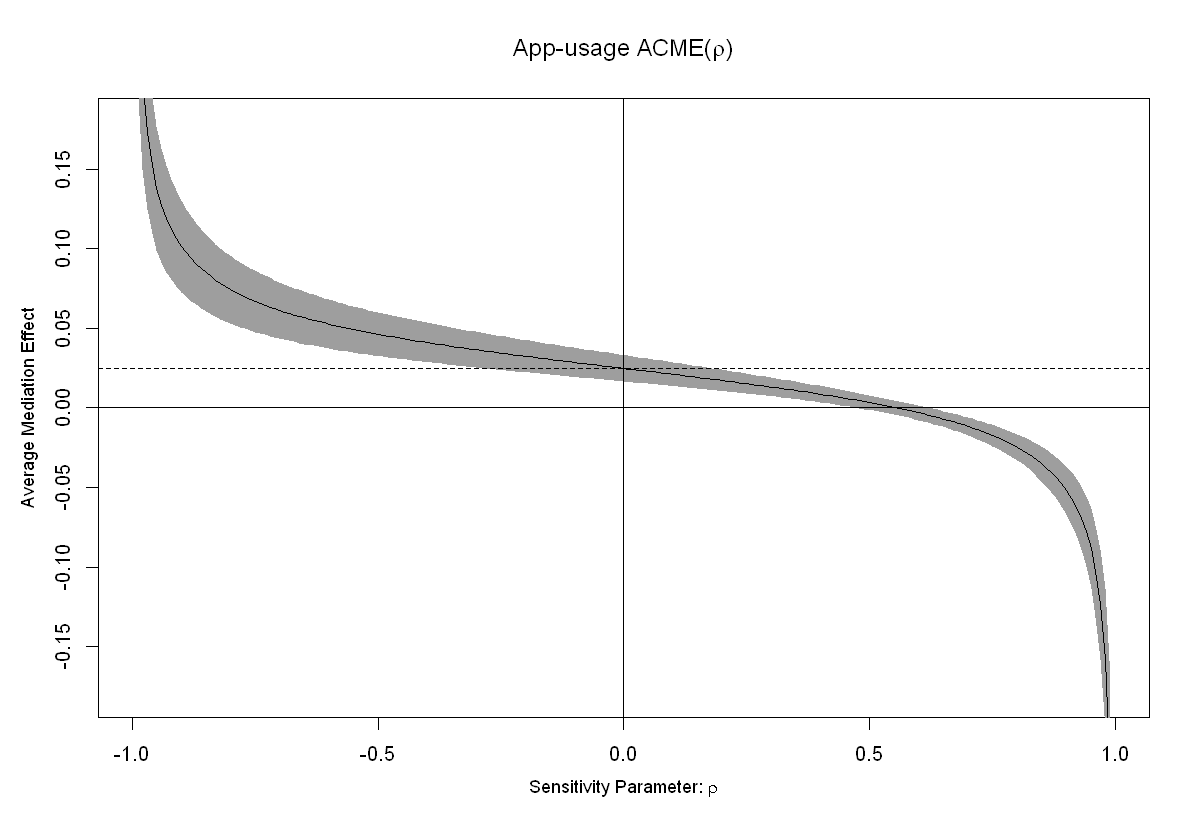

In [29]:
options(repr.plot.width = 10, repr.plot.height = 7)
plot(sens4Month.out,  ylim = c(-0.18, 0.18), main  =  expression(paste("App-usage ACME(", rho, ")")))

The above figure shows the estimated true values of ACMEs as a function of the sensitivity parameter $\rho$. The parameter $\rho$
expresses the correlation between the error terms in the mediator and the outcome models. The solid thick line and its shaded area represent the ACME's point estimates and their 90% confidence intervals, respectively.    
According to this analysis, the ACME is estimated to be negative when  $\rho$ is larger than 0.52, and the ACME is statistically indistinguishable from zero at the 90% level when the parameter $\rho$ is larger than 0.41.

#### Sensitivity with respect to proportion of variance explained

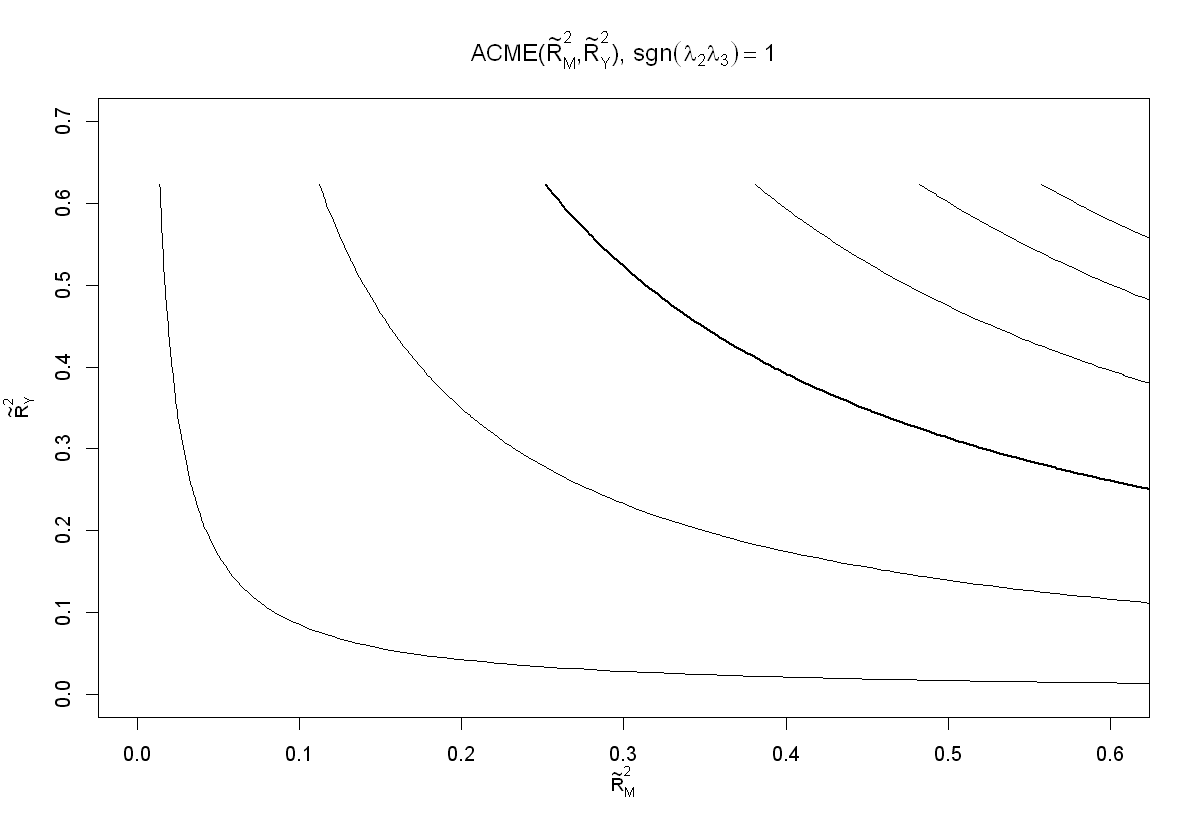

In [30]:
plot(sens4Month.out, sens.par = "R2", r.type = "total", sign.prod = "positive",
     xlim = c(-0.0, 0.6), ylim = c(-0.0, 0.7))

In the sensitivity analyses plot above, the ACME estimates are plotted against $\tilde{R}^2_Y \tilde{R}^2_M$, the proportions of the total variance in the outcome and mediator variables, respectively, that would be explained by a hypothetical unobserved pretreatment confounder.
In terms of the coefficient of determination parameters, the product of $\tilde{R}^2_M$ and $\tilde{R}^2_Y$ must be at least as large
as 0.0518, implying that an unobserved pretreatment confounder must explain 20% of the variation in the participants’ 4-month weight loss and 69.1% of the variation in their weight loss, for example.

### App-usage

#### Results

In [31]:
summary(sensApp.out)


Mediation Sensitivity Analysis for Average Causal Mediation Effect

Sensitivity Region

       Rho    ACME 90% CI Lower 90% CI Upper R^2_M*R^2_Y* R^2_M~R^2_Y~
 [1,] 0.14  0.0085      -0.0007       0.0177       0.0196       0.0102
 [2,] 0.15  0.0077      -0.0015       0.0169       0.0225       0.0117
 [3,] 0.16  0.0069      -0.0023       0.0161       0.0256       0.0134
 [4,] 0.17  0.0061      -0.0030       0.0153       0.0289       0.0151
 [5,] 0.18  0.0053      -0.0038       0.0145       0.0324       0.0169
 [6,] 0.19  0.0045      -0.0046       0.0137       0.0361       0.0188
 [7,] 0.20  0.0037      -0.0054       0.0128       0.0400       0.0209
 [8,] 0.21  0.0029      -0.0062       0.0120       0.0441       0.0230
 [9,] 0.22  0.0021      -0.0070       0.0112       0.0484       0.0253
[10,] 0.23  0.0013      -0.0079       0.0104       0.0529       0.0276
[11,] 0.24  0.0004      -0.0087       0.0095       0.0576       0.0301
[12,] 0.25 -0.0004      -0.0095       0.0087       0.0625  

#### Sensitivity with respect to error correlation

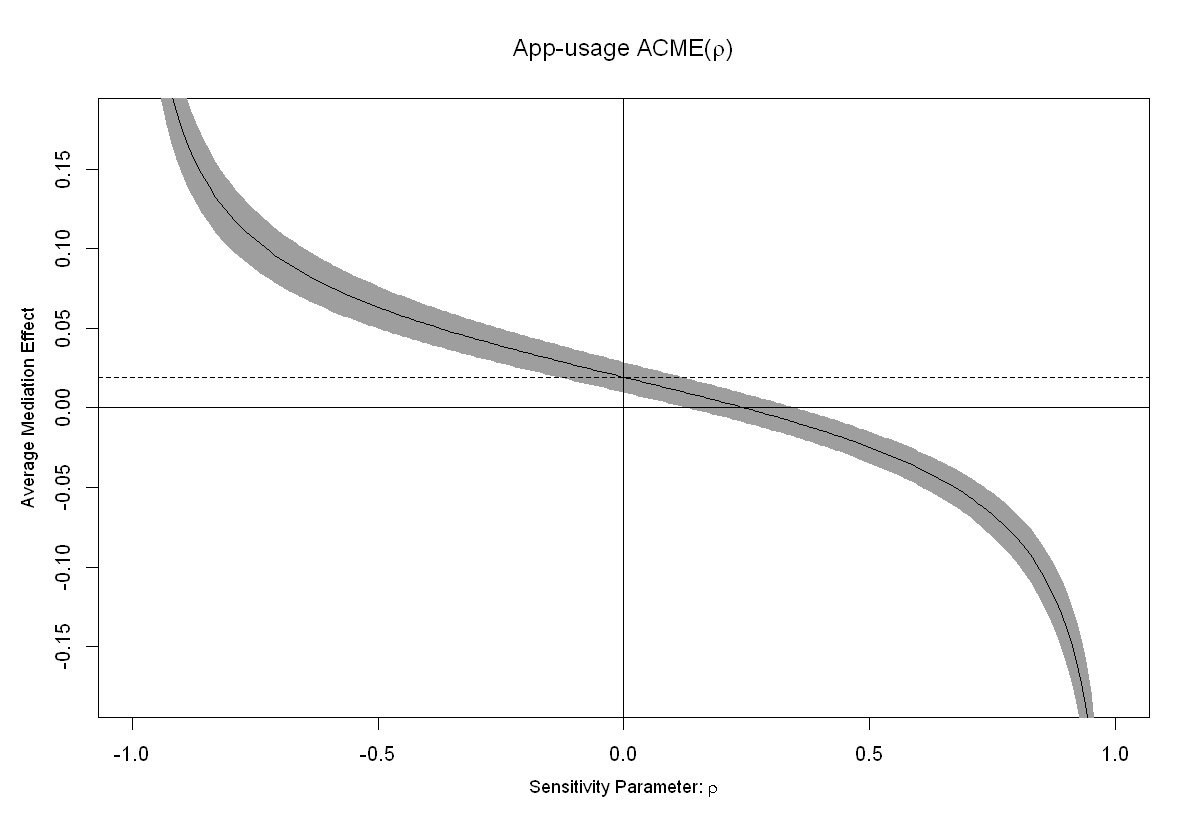

In [32]:
options(repr.plot.width = 10, repr.plot.height = 7)
plot(sensApp.out,  ylim = c(-0.18, 0.18), main  =  expression(paste("App-usage ACME(", rho, ")")))

The above figure shows the estimated true values of ACMEs as a function of the sensitivity parameter $\rho$. The parameter $\rho$
expresses the correlation between the error terms in the mediator and the outcome models. The solid thick line and its shaded area represent the ACME's point estimates and their 90% confidence intervals, respectively.    
According to this analysis, the ACME is estimated to be negative when  $\rho$ is larger than 0.16, and the ACME is statistically indistinguishable from zero at the 90% level when the parameter $\rho$ is larger than 0.01.

#### Sensitivity with respect to proportion of variance explained

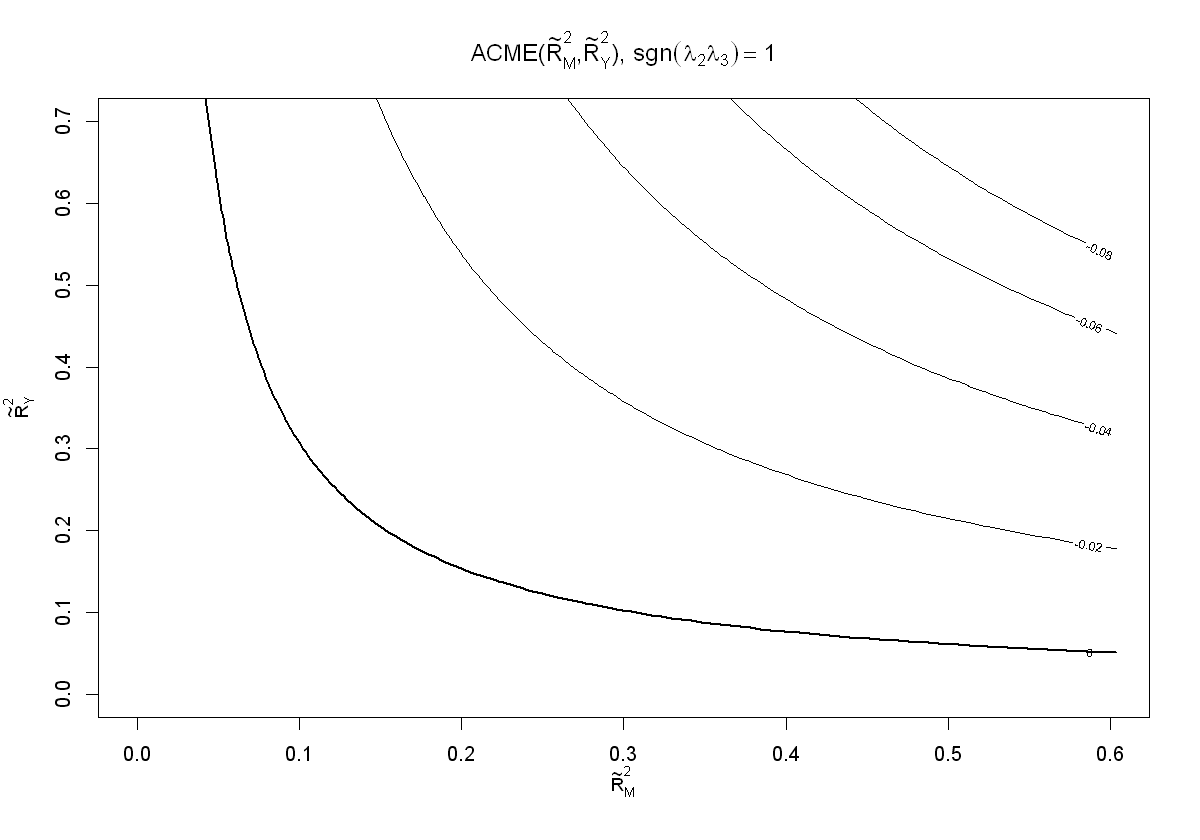

In [33]:
plot(sensApp.out, sens.par = "R2", r.type = "total", sign.prod = "positive",
     xlim = c(-0.0, 0.6), ylim = c(-0.0, 0.7))

In the sensitivity analyses plot above, the ACME estimates are plotted against $\tilde{R}^2_Y \tilde{R}^2_M$, the proportions of the total variance in the outcome and mediator variables, respectively, that would be explained by a hypothetical unobserved pretreatment confounder.
In terms of the coefficient of determination parameters, the product of $\tilde{R}^2_M$ and $\tilde{R}^2_Y$ must be at least as large
as 0.0127, implying that an unobserved pretreatment confounder must explain 20% of the variation in the participants’ app-usage and 6.3% of the variation in their weight loss, for example.


### Self-weight

#### Results

In [34]:
summary(sensNumW.out)


Mediation Sensitivity Analysis for Average Causal Mediation Effect

Sensitivity Region

       Rho    ACME 90% CI Lower 90% CI Upper R^2_M*R^2_Y* R^2_M~R^2_Y~
 [1,] 0.24  0.0044      -0.0003       0.0091       0.0576       0.0388
 [2,] 0.25  0.0040      -0.0007       0.0087       0.0625       0.0421
 [3,] 0.26  0.0036      -0.0011       0.0082       0.0676       0.0455
 [4,] 0.27  0.0032      -0.0015       0.0078       0.0729       0.0491
 [5,] 0.28  0.0027      -0.0018       0.0073       0.0784       0.0528
 [6,] 0.29  0.0023      -0.0022       0.0069       0.0841       0.0567
 [7,] 0.30  0.0019      -0.0027       0.0064       0.0900       0.0606
 [8,] 0.31  0.0015      -0.0031       0.0060       0.0961       0.0647
 [9,] 0.32  0.0010      -0.0035       0.0055       0.1024       0.0690
[10,] 0.33  0.0006      -0.0039       0.0051       0.1089       0.0734
[11,] 0.34  0.0002      -0.0043       0.0047       0.1156       0.0779
[12,] 0.35 -0.0003      -0.0048       0.0042       0.1225  

#### Sensitivity with respect to error correlation

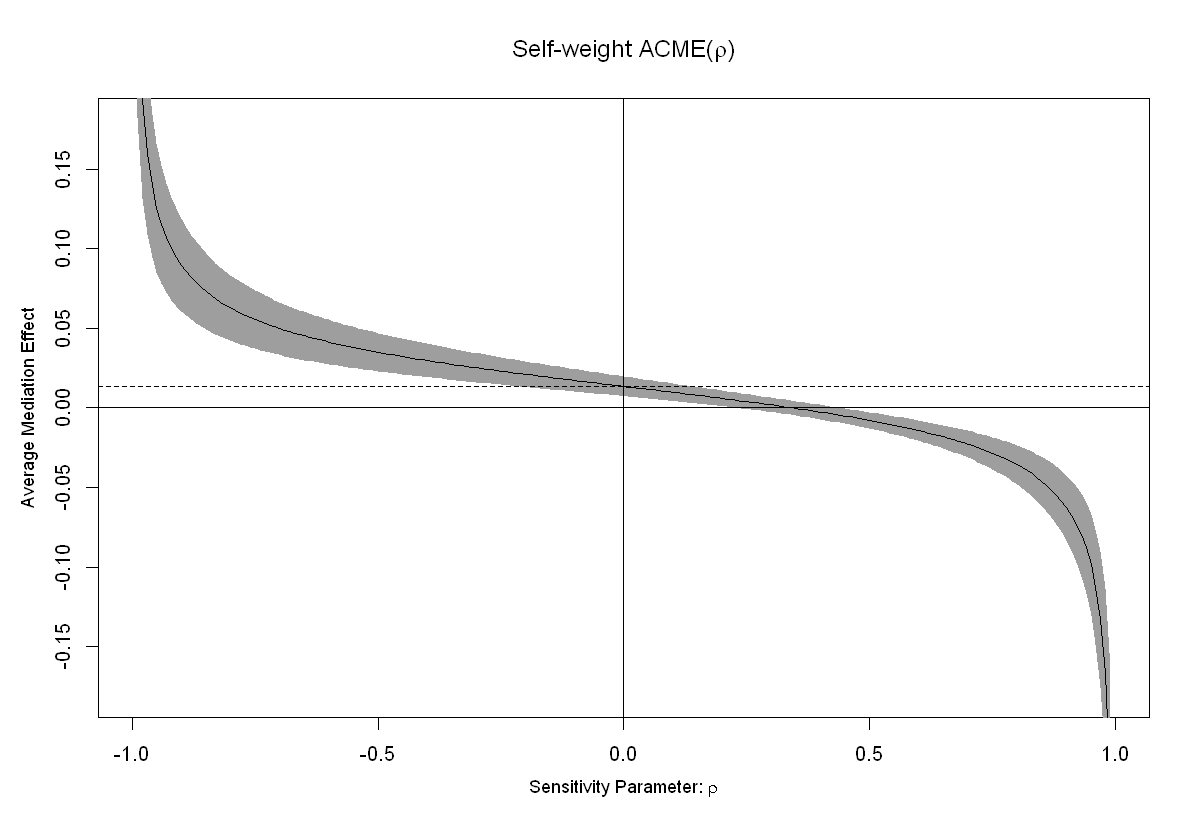

In [35]:
plot(sensNumW.out,  ylim = c(-0.18, 0.18), main  =  expression(paste("Self-weight ACME(", rho, ")")))

The above figure shows the estimated true values of ACMEs as a function of the sensitivity parameter $\rho$. The parameter $\rho$
expresses the correlation between the error terms in the mediator and the outcome models. The solid thick line and its shaded area represent the ACME's point estimates and their 90% confidence intervals, respectively.    
According to this analysis, the ACME is estimated to be negative when  $\rho$ is larger than 0.28, and the ACME is statistically indistinguishable from zero at the 90% level when the parameter $\rho$ is larger than 0.13.

### Sensitivity with respect to proportion of variance explained

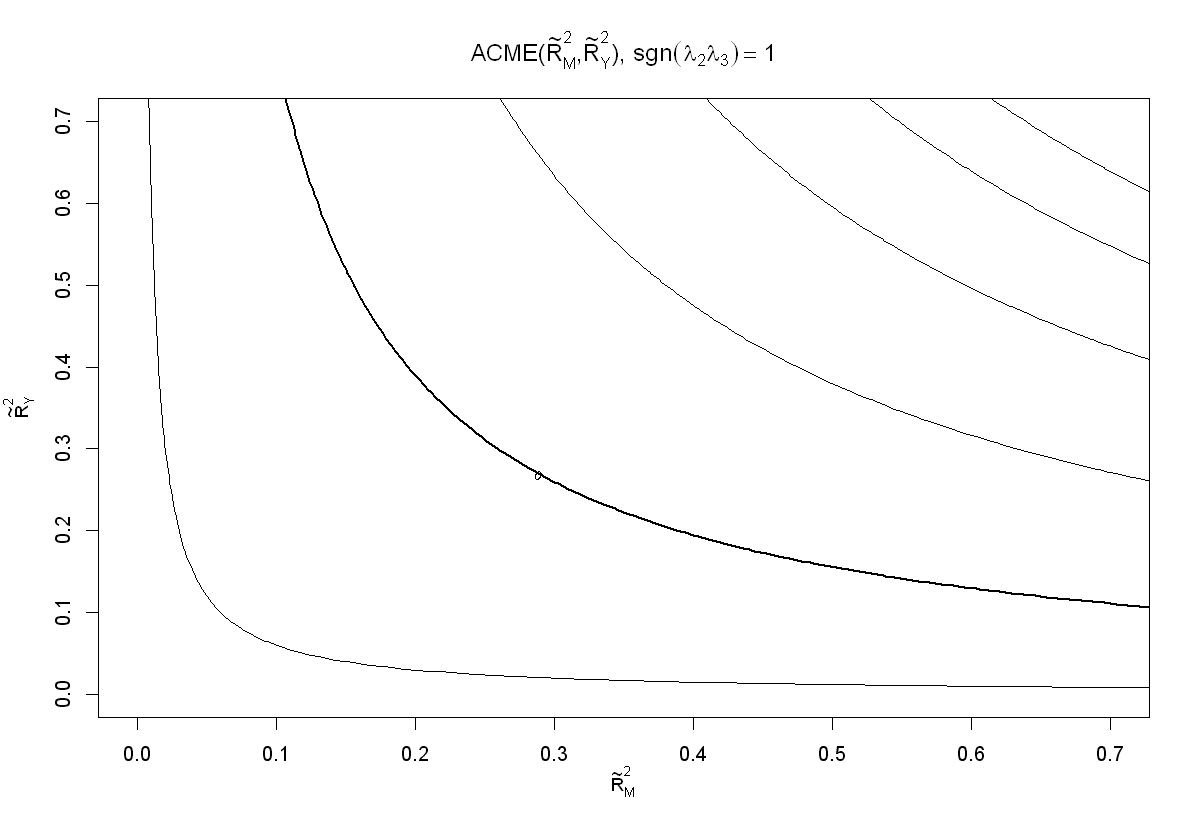

In [36]:
plot(sensNumW.out, sens.par = "R2", r.type = "total", sign.prod = "positive",
     xlim = c(-0.0, 0.7), ylim = c(-0.0, 0.7))

In the sensitivity analyses plot above, the ACME estimates are plotted against $\tilde{R}^2_Y \tilde{R}^2_M$, the proportions of the total variance in the outcome and mediator variables, respectively, that would be explained by a hypothetical unobserved pretreatment confounder.
In terms of the coefficient of determination parameters, the product of $\tilde{R}^2_M$ and $\tilde{R}^2_Y$ must be at least as large
as 0.0523, implying that an unobserved pretreatment confounder must explain 20% of the variation in the participants’ app-usage and 26.1% of the variation in their weight loss, for example.

## Conclusion

Overall, the results suggest that under the assumption of independence between mechanisms, the causal mediation effects are positive and not significant for the app-usage and it is significant for the self weight and for the 4-month weight loss mediator, and the estimates for the 4-month weight loss showed robustness to the
possible unobserved pretreatment mediator–outcome confounding to varying degrees. However, the estimates for app-usage are not robust to the
possible unobserved pretreatment mediator–outcome confounding to varying degrees.